===== 1. 데이터 로드 및 전처리 =====
데이터 크기: (3623, 40)

===== 2. 다중공선성(VIF) 분석 =====

[매출_성과] VIF 상위 3개:
       feature       VIF
1  매출구간_단기_변화율  1.067162
0  매출구간_장기_변화율  1.067162

[장기_트렌드] VIF 상위 3개:
                feature       VIF
0           매출구간_장기_변화율       inf
1         매출구간_장기_변화율.1       inf
9  장기_여성 20대이하 고객 비중_변화  4.999023

[단기_트렌드] VIF 상위 3개:
               feature       VIF
0          매출구간_단기_변화율       inf
1        매출구간_단기_변화율.1       inf
13  단기_남성 50대 고객 비중_변화  5.953039

===== 3. 데이터 분할 및 SMOTE 적용 =====
증강 전 클래스 분포: {0: 2818, 1: 80}
증강 후 클래스 분포: {0: 2818, 1: 2818}

===== 4. 변수 중요도 산출 =====


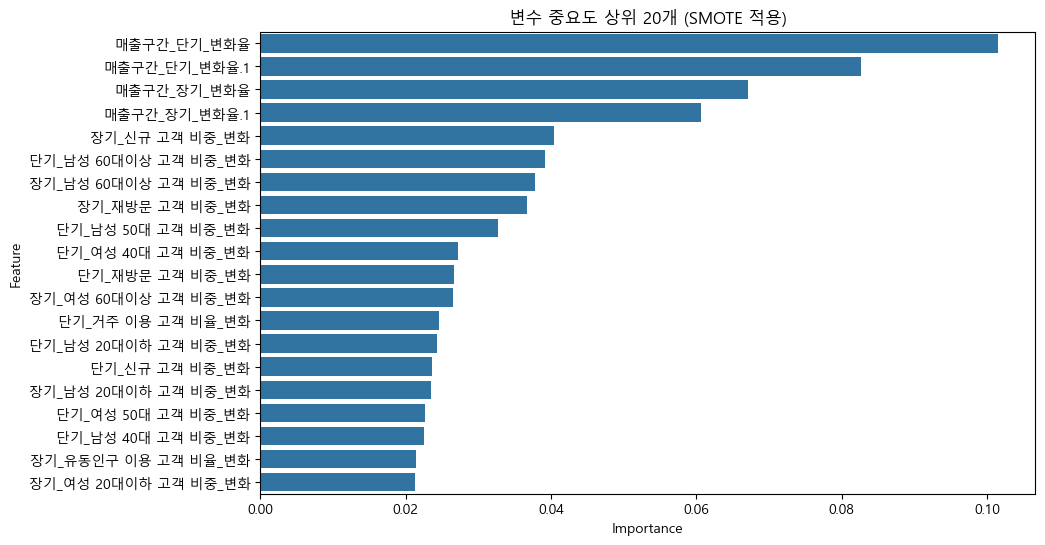


===== 5. 최적 피처 개수(K) 탐색 =====
상위 2개 피처 사용 -> Recall: 0.0000
상위 7개 피처 사용 -> Recall: 0.0500
상위 12개 피처 사용 -> Recall: 0.0000
상위 17개 피처 사용 -> Recall: 0.0000
상위 22개 피처 사용 -> Recall: 0.0000
상위 27개 피처 사용 -> Recall: 0.0000
상위 32개 피처 사용 -> Recall: 0.0000


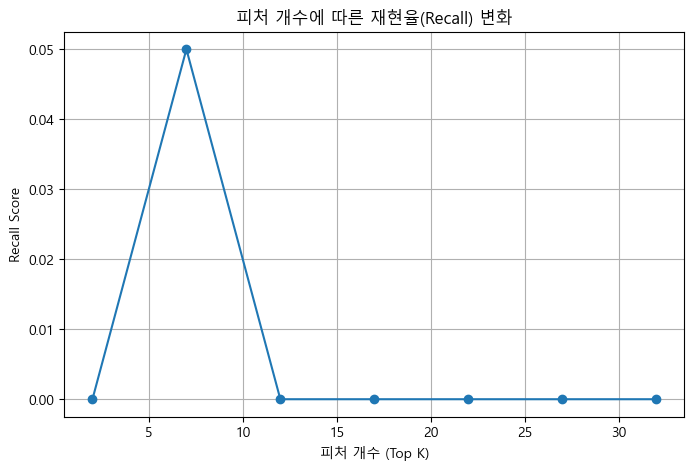


최적 피처 개수: 7개 (Recall: 0.0500)

===== 6. 최종 데이터 저장 =====
저장 완료: ./data/real_final_data.csv (컬럼 수: 12개)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

# 환경 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# 1. 데이터 로드 및 전처리
# -----------------------------------------------------------------------------
print("===== 1. 데이터 로드 및 전처리 =====")
df = pd.read_csv('./data/final_df.csv', encoding='utf-8-sig')
df = df.dropna()

# 분석에 불필요한 컬럼 제거
cols_drop = ['업종', '도로명주소_세부', '개설일']
df.drop(columns=[c for c in cols_drop if c in df.columns], axis=1, inplace=True)

# 컬럼 순서 재정의 (메타 정보 우선 배치)
target_cols_order = [
    '가맹점구분번호', '업종_대분류', '상권', '도로명주소', '영업기간_구간',
    '매출금액_안정성_지수', '매출구간_장기_변화율', '매출구간_단기_변화율',
    '23_24_유니크고객수_변화', '23_24_객단가_변화', '23_24_동일 업종 매출금액 비율_변화',
    '23_24_동일 업종 매출건수 비율_변화', '23_24_동일 업종 내 매출 순위 비율_변화', '23_24_동일 상권 내 매출 순위 비율_변화',
    '폐업여부'
]
# 실제 존재하는 컬럼만 선택하여 정렬
existing_cols = [col for col in target_cols_order if col in df.columns]
remaining_cols = [col for col in df.columns if col not in existing_cols]
df = df[existing_cols + remaining_cols]

print(f"데이터 크기: {df.shape}")

# -----------------------------------------------------------------------------
# 2. 다중공선성(VIF) 분석
# -----------------------------------------------------------------------------
print("\n===== 2. 다중공선성(VIF) 분석 =====")

feature_groups = {
    '매출_성과': ['매출금액_안정성_지수', '매출구간_장기_변화율', '매출구간_단기_변화율'],
    '고객_경쟁': ['23_24_유니크고객수_변화', '23_24_객단가_변화', '23_24_동일 업종 매출금액 비율_변화', 
                '23_24_동일 업종 매출건수 비율_변화', '23_24_동일 업종 내 매출 순위 비율_변화', '23_24_동일 상권 내 매출 순위 비율_변화'],
    '장기_트렌드': [c for c in df.columns if '장기_' in c and '변화' in c],
    '단기_트렌드': [c for c in df.columns if '단기_' in c and '변화' in c]
}

for group, feats in feature_groups.items():
    valid_feats = [f for f in feats if f in df.columns]
    if not valid_feats: continue
    
    # 숫자형 데이터 선택 및 상수항 추가
    X_group = df[valid_feats].select_dtypes(include=np.number)
    if X_group.empty: continue
    
    X_group_const = sm.add_constant(X_group)
    
    try:
        vif_data = pd.DataFrame()
        vif_data["feature"] = X_group.columns
        vif_data["VIF"] = [variance_inflation_factor(X_group_const.values, i+1) 
                           for i in range(len(X_group.columns))]
        
        print(f"\n[{group}] VIF 상위 3개:")
        print(vif_data.sort_values("VIF", ascending=False).head(3))
        
    except Exception as e:
        print(f"[{group}] VIF 계산 중 오류: {e}")

# -----------------------------------------------------------------------------
# 3. 데이터 분할 및 SMOTE 적용
# -----------------------------------------------------------------------------
print("\n===== 3. 데이터 분할 및 SMOTE 적용 =====")

target = '폐업여부'
ignore_cols = ['가맹점구분번호', '업종_대분류', '상권', '도로명주소', '영업기간_구간']
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [target] + ignore_cols]

X = df[numeric_cols]
y = df[target]

# 훈련/테스트 분리 (층화 추출)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE 적용 (훈련 데이터만 적용)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"증강 전 클래스 분포: {y_train.value_counts().to_dict()}")
print(f"증강 후 클래스 분포: {y_train_res.value_counts().to_dict()}")

# -----------------------------------------------------------------------------
# 4. 변수 중요도 산출
# -----------------------------------------------------------------------------
print("\n===== 4. 변수 중요도 산출 =====")

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

# 중요도 데이터프레임 생성
imp_df = pd.DataFrame({'Feature': numeric_cols, 'Importance': rf.feature_importances_})
imp_df = imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(20))
plt.title("변수 중요도 상위 20개 (SMOTE 적용)")
plt.show()

# -----------------------------------------------------------------------------
# 5. 최적 피처 개수(K) 탐색 (Recall 기준)
# -----------------------------------------------------------------------------
print("\n===== 5. 최적 피처 개수(K) 탐색 =====")

recall_scores = []
k_range = range(2, len(numeric_cols) + 1, 5)
sorted_feats = imp_df['Feature'].tolist()

for k in k_range:
    top_k = sorted_feats[:k]
    
    # 선택된 상위 K개 피처로 데이터 구성
    X_tr_k = X_train_res[top_k]
    X_te_k = X_test[top_k]
    
    # 모델 학습 및 평가
    model_k = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_k.fit(X_tr_k, y_train_res)
    
    pred = model_k.predict(X_te_k)
    recall = recall_score(y_test, pred, pos_label=1)
    recall_scores.append(recall)
    print(f"상위 {k}개 피처 사용 -> Recall: {recall:.4f}")

# 결과 시각화
plt.figure(figsize=(8, 5))
plt.plot(k_range, recall_scores, marker='o')
plt.title("피처 개수에 따른 재현율(Recall) 변화")
plt.xlabel("피처 개수 (Top K)")
plt.ylabel("Recall Score")
plt.grid(True)
plt.show()

# 최적 K 도출
best_idx = np.argmax(recall_scores)
best_k = list(k_range)[best_idx]
print(f"\n최적 피처 개수: {best_k}개 (Recall: {recall_scores[best_idx]:.4f})")

# -----------------------------------------------------------------------------
# 6. 최종 데이터 저장
# -----------------------------------------------------------------------------
print("\n===== 6. 최종 데이터 저장 =====")

cols_meta = ['가맹점구분번호', '업종_대분류', '상권', '영업기간_구간']
cols_best = sorted_feats[:best_k] # 최적 피처 개수만큼 선택
cols_target = ['폐업여부']

final_cols = cols_meta + cols_best + cols_target
real_final_df = df[final_cols].copy()

real_final_df.to_csv('./data/real_final_data.csv', encoding='utf-8-sig', index=False)
print(f"저장 완료: ./data/real_final_data.csv (컬럼 수: {len(final_cols)}개)")